<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Для работы были предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо постройте модель с предельно большим значением *F1*-меры. Для успешного выполнения задачи, нужно довести метрику до 0.59.

Дополнительно измерить *AUC-ROC*, и сравнить её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve 
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Около тысячи пропусков было обнаружено в столбце Tenure, что составляет 10% от суммарного количества данных. В стоблце заменим пропущенные значения медианным: так данные слабо повлияют на общее распределение:

In [4]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data['Tenure'].isna().sum()

0

В остальном, типы данных по смыслу соответствуют категории данных: года измерены в целых числах, пол клиента характеризуется object (str) и т.д.

In [5]:
#data.describe()
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Соотношение классов целевого признака далеко от 1:1 (приблизительно 1:4), что может плохо сказазаться на обучении модели в будущем. Скорее всего, наблюдается **дисбаланс классов**



In [6]:
data_new = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data_new.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Индекс строки в данных, уникальный идентификатор клиента и его фамилия никак не помогут модели предугадать уход клиента, лишь только запутают её. Поэтому стоит удалить первые три столбца при исследовании моделей

## Исследование задачи

Судя по предыдущему наблюдению, в наших данных наблюдается дисбаланс классов. Изучим работоспособность моделей без учёта дисбаланса классов. Также применим аргумент stratify, который позволит сохранить изначальное распределение таргетов во всех новых датасетах:

In [7]:
target = data_new['Exited']
features = data_new.drop('Exited', axis=1)

features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_and_test, target_valid_and_test, test_size=0.5, random_state=12345, stratify=target_valid_and_test)

features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

Совместили кодирование категориальных и масштабирование численных признаков, а также провели разделение наши данные на тестовую и валидационную выборки. Теперь проверим accuracy для решающего дерева, а также частоты классов в результатах предсказаний:

accuracy для решающего дерева:  0.793
0    0.787
1    0.213
dtype: float64


<AxesSubplot:>

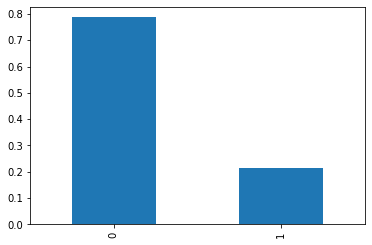

In [8]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

accuracy_valid = accuracy_score(target_valid, predicted_valid)
print('accuracy для решающего дерева: ', accuracy_valid)

predicted_valid = pd.Series(model.predict(features_valid))

class_frequency = predicted_valid.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

В результате обучения решающего дерева на тренировочной выборке и последующего предсказания результатов валидационной выборки, можно заметить:

1. Значение accurecy для всех классов максимально приближено к accurecy класса "0"
2. Значение accurecy класса "0" почти в 3.5 раза больше значения accurecy класса "1"

Всё это ещё раз говорит об отсутствии балланса классов. Следовательно, accuracy не подойдёт для оценки качества работы нашей модели. Нужно использовать метрику F1.

## Борьба с дисбалансом

Определим F1-меру для дерева решений:

In [21]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print('Значение F1-меры: ', f1_score(target_valid, predicted_valid))

Значение F1-меры:  0.6126656848306332


 Для выполнения задания, нужно довести метрику до 0.59. Сравним эффект от применения upsample и downsample, а также попромуем изменить пороговое значение класса для модели логистической регрессии:

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = RandomForestClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6358839050131926


In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.55)

model = RandomForestClassifier(random_state=12345, n_estimators=90, max_depth=23)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.6573957016434893


Значение accuracy сильнее увеличилось при применении техники downsample. Добавим оптимальное значение гиперпараметра глубины дерева в нашу модель для улучшение метрики F1:

In [10]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.55)

best_result = 0
for n_estimators in tqdm(range(3,58)):
    for depth in range(1, 25):
        model = RandomForestClassifier(max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_result = result
            best_depth = depth

print("F1 наилучшей модели на валидационной выборке:", best_result, "Максимальная глубина:", best_depth)

100%|██████████| 55/55 [09:59<00:00, 10.90s/it]

F1 наилучшей модели на валидационной выборке: 0.6572528883183568 Максимальная глубина: 11


In [11]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.55)

best_result = 0
for n_estimators in tqdm(range(3,58)):
    for est in range(1, 100):
        model = RandomForestClassifier(n_estimators=est, max_depth=10, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_result = result
            best_est = est

print("F1 наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est)

100%|██████████| 55/55 [20:49<00:00, 22.73s/it]

F1 наилучшей модели на валидационной выборке: 0.6598465473145779 Количество деревьев: 20


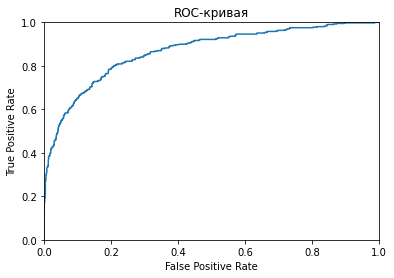

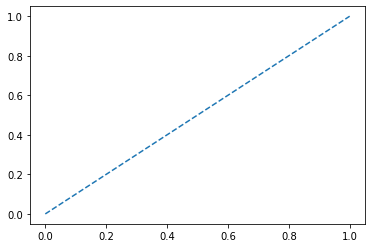

AUC-ROC: 0.8672575500049267


In [15]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC:', auc_roc)

**Вывод:** в результате уменьшения выборки при применении техники downsampling и добавления оптимального значения гиперпараметра глубины деревьев, удалось построить модель с предельно большим значением F1-меры, равным 0.65 (значение увеличилось от первоноачальной модели на 0.04)

ROC-кривая идёт из левого нижнего угла в верхний правый, что указывает на то, что наша модель отвечает случайно, а высота графика свидетельствует о достаточно высоком качестве модели. Высокое значение метрики AUC-ROC (больше значения метрики случайной модели) вновь указывает на высокое качество модели

## Тестирование модели

In [9]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.55)

model = RandomForestClassifier(n_estimators=90, max_depth=23, random_state=12345)
model.fit(features_downsampled, target_downsampled)
result = model.score(features_valid, target_valid)
test_predictions = model.predict(features_test)

def error_count(answers, predictions):
    answers=answers.tolist()
    predictions=predictions.tolist()
    error_number=0
    for i in range(len(answers)):
        if answers[i] != predictions[i]:
            error_number+=1
    return error_number

print("Ошибок:", error_count(target_test, test_predictions), "из", len(target_test),'\nAccuracy:', result)
print('F-1 мера: ', f1_score(target_test, test_predictions))

Ошибок: 318 из 2000 
Accuracy: 0.8645
F-1 мера:  0.5984848484848485


**Вывод:** в результате удалось обучить модель случайного леса, имеющую F1-меру, большую 0.59, и accuracy, равную 0.864, что соответствует условию выполнения поставленной задачи.

Для достижения этого результата, была проведена работа с данными (замена пропусков на медианные значения, удаление лишних столбцов), экспериментирование с различными техниками повышения значения F1-меры, подборка максимально точных моделей и их гиперпараметров. Итоговый результат рекомендуется использовать для предсказания поведения клиентов. 